##### Copyright 2020 The TensorFlow Hub Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 48.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [2]:
!pip install -q tf-models-official==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following de

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 5s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [7]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Let's take a look at a few reviews.

In [8]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [9]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611856  0.36673826  0.15233693  0.65504473
  0.9681154  -0.94862705  0.0021619  -0.9877732   0.06842698 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321284  0.3323149  ...  0.21300808  0.71020824
  -0.05771172]
 [-0.2874203   0.31981018 -0.2301853  ...  0.58455014 -0.21329692
   0.7269214 ]
 [-0.66157     0.6887689  -0.8743298  ...  0.10877271 -0.26173168
   0.47855347]
 ...
 [-0.22561166 -0.28925633 -0.07064366 ...  0.47566074  0.83277154
   0.4002533 ]
 [-0.29824263 -0.2747314  -0.05450518 ...  0.48849723  1.095536
   0.18163356]
 [-0.443782    0.00930692  0.07223746 ...  0.17290054  1.1833245
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [11]:
classifier_model = build_classifier_model()

The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

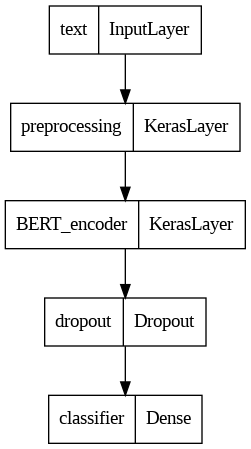

In [12]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [13]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [14]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [15]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [16]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/5
  2/625 [..............................] - ETA: 10:05:45 - loss: 0.7765 - binary_accuracy: 0.4531

KeyboardInterrupt: ignored

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:17 - loss: 0.4579 - binary_accuracy: 0.8438

  2/782 [..............................] - ETA: 57s - loss: 0.3332 - binary_accuracy: 0.8906 

  3/782 [..............................] - ETA: 57s - loss: 0.3902 - binary_accuracy: 0.8750

  4/782 [..............................] - ETA: 57s - loss: 0.3330 - binary_accuracy: 0.8750

  5/782 [..............................] - ETA: 56s - loss: 0.3071 - binary_accuracy: 0.8750

  6/782 [..............................] - ETA: 56s - loss: 0.3720 - binary_accuracy: 0.8438

  7/782 [..............................] - ETA: 56s - loss: 0.3410 - binary_accuracy: 0.8616

  8/782 [..............................] - ETA: 56s - loss: 0.3895 - binary_accuracy: 0.8555

  9/782 [..............................] - ETA: 55s - loss: 0.4124 - binary_accuracy: 0.8507

 10/782 [..............................] - ETA: 55s - loss: 0.4356 - binary_accuracy: 0.8438

 11/782 [..............................] - ETA: 55s - loss: 0.4162 - binary_accuracy: 0.8494

 12/782 [..............................] - ETA: 55s - loss: 0.4250 - binary_accuracy: 0.8490

 13/782 [..............................] - ETA: 56s - loss: 0.4510 - binary_accuracy: 0.8462

 14/782 [..............................] - ETA: 55s - loss: 0.4503 - binary_accuracy: 0.8482

 15/782 [..............................] - ETA: 56s - loss: 0.4477 - binary_accuracy: 0.8521

 16/782 [..............................] - ETA: 55s - loss: 0.4525 - binary_accuracy: 0.8496

 17/782 [..............................] - ETA: 56s - loss: 0.4357 - binary_accuracy: 0.8529

 18/782 [..............................] - ETA: 55s - loss: 0.4335 - binary_accuracy: 0.8542

 19/782 [..............................] - ETA: 55s - loss: 0.4318 - binary_accuracy: 0.8553

 20/782 [..............................] - ETA: 55s - loss: 0.4494 - binary_accuracy: 0.8516

 21/782 [..............................] - ETA: 55s - loss: 0.4374 - binary_accuracy: 0.8542

 22/782 [..............................] - ETA: 55s - loss: 0.4298 - binary_accuracy: 0.8551

 23/782 [..............................] - ETA: 55s - loss: 0.4307 - binary_accuracy: 0.8546

 24/782 [..............................] - ETA: 55s - loss: 0.4144 - binary_accuracy: 0.8594

 25/782 [..............................] - ETA: 55s - loss: 0.4145 - binary_accuracy: 0.8600

 26/782 [..............................] - ETA: 54s - loss: 0.4022 - binary_accuracy: 0.8630

 27/782 [>.............................] - ETA: 54s - loss: 0.3972 - binary_accuracy: 0.8657

 28/782 [>.............................] - ETA: 54s - loss: 0.4035 - binary_accuracy: 0.8638

 29/782 [>.............................] - ETA: 54s - loss: 0.3937 - binary_accuracy: 0.8664

 30/782 [>.............................] - ETA: 54s - loss: 0.4022 - binary_accuracy: 0.8656

 31/782 [>.............................] - ETA: 54s - loss: 0.4071 - binary_accuracy: 0.8629

 32/782 [>.............................] - ETA: 54s - loss: 0.4064 - binary_accuracy: 0.8623

 33/782 [>.............................] - ETA: 54s - loss: 0.4166 - binary_accuracy: 0.8589

 34/782 [>.............................] - ETA: 54s - loss: 0.4130 - binary_accuracy: 0.8612

 35/782 [>.............................] - ETA: 54s - loss: 0.4251 - binary_accuracy: 0.8589

 36/782 [>.............................] - ETA: 54s - loss: 0.4283 - binary_accuracy: 0.8594

 37/782 [>.............................] - ETA: 53s - loss: 0.4357 - binary_accuracy: 0.8564

 38/782 [>.............................] - ETA: 53s - loss: 0.4382 - binary_accuracy: 0.8569

 39/782 [>.............................] - ETA: 53s - loss: 0.4328 - binary_accuracy: 0.8566

 40/782 [>.............................] - ETA: 53s - loss: 0.4282 - binary_accuracy: 0.8578

 41/782 [>.............................] - ETA: 53s - loss: 0.4269 - binary_accuracy: 0.8582

 42/782 [>.............................] - ETA: 53s - loss: 0.4378 - binary_accuracy: 0.8557

 43/782 [>.............................] - ETA: 53s - loss: 0.4349 - binary_accuracy: 0.8568

 44/782 [>.............................] - ETA: 53s - loss: 0.4401 - binary_accuracy: 0.8565

 45/782 [>.............................] - ETA: 53s - loss: 0.4405 - binary_accuracy: 0.8562

 46/782 [>.............................] - ETA: 53s - loss: 0.4413 - binary_accuracy: 0.8560

 47/782 [>.............................] - ETA: 53s - loss: 0.4359 - binary_accuracy: 0.8577

 48/782 [>.............................] - ETA: 53s - loss: 0.4327 - binary_accuracy: 0.8581

 49/782 [>.............................] - ETA: 53s - loss: 0.4367 - binary_accuracy: 0.8591

 50/782 [>.............................] - ETA: 53s - loss: 0.4380 - binary_accuracy: 0.8600

 51/782 [>.............................] - ETA: 53s - loss: 0.4367 - binary_accuracy: 0.8609

 52/782 [>.............................] - ETA: 53s - loss: 0.4375 - binary_accuracy: 0.8612

 53/782 [=>............................] - ETA: 53s - loss: 0.4428 - binary_accuracy: 0.8603

 54/782 [=>............................] - ETA: 53s - loss: 0.4375 - binary_accuracy: 0.8623

 55/782 [=>............................] - ETA: 53s - loss: 0.4314 - binary_accuracy: 0.8642

 56/782 [=>............................] - ETA: 53s - loss: 0.4278 - binary_accuracy: 0.8661

 57/782 [=>............................] - ETA: 52s - loss: 0.4284 - binary_accuracy: 0.8668

 58/782 [=>............................] - ETA: 52s - loss: 0.4267 - binary_accuracy: 0.8675

 59/782 [=>............................] - ETA: 52s - loss: 0.4241 - binary_accuracy: 0.8676

 60/782 [=>............................] - ETA: 52s - loss: 0.4206 - binary_accuracy: 0.8682

 61/782 [=>............................] - ETA: 52s - loss: 0.4149 - binary_accuracy: 0.8694

 62/782 [=>............................] - ETA: 52s - loss: 0.4135 - binary_accuracy: 0.8695

 63/782 [=>............................] - ETA: 52s - loss: 0.4160 - binary_accuracy: 0.8686

 64/782 [=>............................] - ETA: 52s - loss: 0.4163 - binary_accuracy: 0.8687

 65/782 [=>............................] - ETA: 52s - loss: 0.4203 - binary_accuracy: 0.8678

 66/782 [=>............................] - ETA: 52s - loss: 0.4244 - binary_accuracy: 0.8674

 67/782 [=>............................] - ETA: 52s - loss: 0.4197 - binary_accuracy: 0.8689

 68/782 [=>............................] - ETA: 51s - loss: 0.4251 - binary_accuracy: 0.8672

 69/782 [=>............................] - ETA: 51s - loss: 0.4234 - binary_accuracy: 0.8682

 70/782 [=>............................] - ETA: 51s - loss: 0.4253 - binary_accuracy: 0.8687

 71/782 [=>............................] - ETA: 51s - loss: 0.4307 - binary_accuracy: 0.8680

 72/782 [=>............................] - ETA: 51s - loss: 0.4303 - binary_accuracy: 0.8681

 73/782 [=>............................] - ETA: 51s - loss: 0.4344 - binary_accuracy: 0.8673

 74/782 [=>............................] - ETA: 51s - loss: 0.4341 - binary_accuracy: 0.8670

 75/782 [=>............................] - ETA: 51s - loss: 0.4334 - binary_accuracy: 0.8671

 76/782 [=>............................] - ETA: 51s - loss: 0.4392 - binary_accuracy: 0.8668

 77/782 [=>............................] - ETA: 51s - loss: 0.4471 - binary_accuracy: 0.8653

 78/782 [=>............................] - ETA: 51s - loss: 0.4486 - binary_accuracy: 0.8650

 79/782 [==>...........................] - ETA: 51s - loss: 0.4485 - binary_accuracy: 0.8651

 80/782 [==>...........................] - ETA: 51s - loss: 0.4485 - binary_accuracy: 0.8648

 81/782 [==>...........................] - ETA: 51s - loss: 0.4468 - binary_accuracy: 0.8654

 82/782 [==>...........................] - ETA: 50s - loss: 0.4476 - binary_accuracy: 0.8651

 83/782 [==>...........................] - ETA: 50s - loss: 0.4506 - binary_accuracy: 0.8645

 84/782 [==>...........................] - ETA: 50s - loss: 0.4522 - binary_accuracy: 0.8646

 85/782 [==>...........................] - ETA: 50s - loss: 0.4500 - binary_accuracy: 0.8651

 86/782 [==>...........................] - ETA: 50s - loss: 0.4573 - binary_accuracy: 0.8630

 87/782 [==>...........................] - ETA: 50s - loss: 0.4570 - binary_accuracy: 0.8631

 88/782 [==>...........................] - ETA: 50s - loss: 0.4553 - binary_accuracy: 0.8633

 89/782 [==>...........................] - ETA: 50s - loss: 0.4551 - binary_accuracy: 0.8634

 90/782 [==>...........................] - ETA: 50s - loss: 0.4542 - binary_accuracy: 0.8635

 91/782 [==>...........................] - ETA: 50s - loss: 0.4529 - binary_accuracy: 0.8640

 92/782 [==>...........................] - ETA: 50s - loss: 0.4528 - binary_accuracy: 0.8638

 93/782 [==>...........................] - ETA: 50s - loss: 0.4511 - binary_accuracy: 0.8646

 94/782 [==>...........................] - ETA: 50s - loss: 0.4488 - binary_accuracy: 0.8654

 95/782 [==>...........................] - ETA: 49s - loss: 0.4473 - binary_accuracy: 0.8655

 96/782 [==>...........................] - ETA: 49s - loss: 0.4440 - binary_accuracy: 0.8662

 97/782 [==>...........................] - ETA: 49s - loss: 0.4431 - binary_accuracy: 0.8660

 98/782 [==>...........................] - ETA: 49s - loss: 0.4430 - binary_accuracy: 0.8658

 99/782 [==>...........................] - ETA: 49s - loss: 0.4434 - binary_accuracy: 0.8662

100/782 [==>...........................] - ETA: 49s - loss: 0.4435 - binary_accuracy: 0.8662

101/782 [==>...........................] - ETA: 49s - loss: 0.4443 - binary_accuracy: 0.8660

102/782 [==>...........................] - ETA: 49s - loss: 0.4438 - binary_accuracy: 0.8664

103/782 [==>...........................] - ETA: 49s - loss: 0.4458 - binary_accuracy: 0.8662

104/782 [==>...........................] - ETA: 49s - loss: 0.4450 - binary_accuracy: 0.8666

105/782 [===>..........................] - ETA: 49s - loss: 0.4445 - binary_accuracy: 0.8670

106/782 [===>..........................] - ETA: 49s - loss: 0.4424 - binary_accuracy: 0.8676

107/782 [===>..........................] - ETA: 49s - loss: 0.4434 - binary_accuracy: 0.8674

108/782 [===>..........................] - ETA: 49s - loss: 0.4418 - binary_accuracy: 0.8675

109/782 [===>..........................] - ETA: 48s - loss: 0.4419 - binary_accuracy: 0.8670

110/782 [===>..........................] - ETA: 48s - loss: 0.4442 - binary_accuracy: 0.8668

111/782 [===>..........................] - ETA: 48s - loss: 0.4450 - binary_accuracy: 0.8666

112/782 [===>..........................] - ETA: 48s - loss: 0.4463 - binary_accuracy: 0.8664

113/782 [===>..........................] - ETA: 48s - loss: 0.4447 - binary_accuracy: 0.8667

114/782 [===>..........................] - ETA: 48s - loss: 0.4456 - binary_accuracy: 0.8662

115/782 [===>..........................] - ETA: 48s - loss: 0.4458 - binary_accuracy: 0.8666

116/782 [===>..........................] - ETA: 48s - loss: 0.4448 - binary_accuracy: 0.8661

117/782 [===>..........................] - ETA: 48s - loss: 0.4425 - binary_accuracy: 0.8667

118/782 [===>..........................] - ETA: 48s - loss: 0.4434 - binary_accuracy: 0.8665

119/782 [===>..........................] - ETA: 48s - loss: 0.4441 - binary_accuracy: 0.8658

120/782 [===>..........................] - ETA: 48s - loss: 0.4458 - binary_accuracy: 0.8654

121/782 [===>..........................] - ETA: 48s - loss: 0.4466 - binary_accuracy: 0.8652

122/782 [===>..........................] - ETA: 48s - loss: 0.4446 - binary_accuracy: 0.8655

123/782 [===>..........................] - ETA: 48s - loss: 0.4482 - binary_accuracy: 0.8648

124/782 [===>..........................] - ETA: 47s - loss: 0.4476 - binary_accuracy: 0.8649

125/782 [===>..........................] - ETA: 47s - loss: 0.4480 - binary_accuracy: 0.8645

126/782 [===>..........................] - ETA: 47s - loss: 0.4448 - binary_accuracy: 0.8653

127/782 [===>..........................] - ETA: 47s - loss: 0.4435 - binary_accuracy: 0.8652

128/782 [===>..........................] - ETA: 47s - loss: 0.4447 - binary_accuracy: 0.8650

129/782 [===>..........................] - ETA: 47s - loss: 0.4457 - binary_accuracy: 0.8646

130/782 [===>..........................] - ETA: 47s - loss: 0.4446 - binary_accuracy: 0.8649

131/782 [====>.........................] - ETA: 47s - loss: 0.4428 - binary_accuracy: 0.8652

132/782 [====>.........................] - ETA: 47s - loss: 0.4431 - binary_accuracy: 0.8653

133/782 [====>.........................] - ETA: 47s - loss: 0.4436 - binary_accuracy: 0.8654

134/782 [====>.........................] - ETA: 47s - loss: 0.4443 - binary_accuracy: 0.8652

135/782 [====>.........................] - ETA: 47s - loss: 0.4457 - binary_accuracy: 0.8648

136/782 [====>.........................] - ETA: 47s - loss: 0.4475 - binary_accuracy: 0.8642

137/782 [====>.........................] - ETA: 47s - loss: 0.4509 - binary_accuracy: 0.8636

138/782 [====>.........................] - ETA: 46s - loss: 0.4517 - binary_accuracy: 0.8632

139/782 [====>.........................] - ETA: 46s - loss: 0.4508 - binary_accuracy: 0.8624

140/782 [====>.........................] - ETA: 46s - loss: 0.4505 - binary_accuracy: 0.8627

141/782 [====>.........................] - ETA: 46s - loss: 0.4547 - binary_accuracy: 0.8624

142/782 [====>.........................] - ETA: 46s - loss: 0.4531 - binary_accuracy: 0.8629

143/782 [====>.........................] - ETA: 46s - loss: 0.4531 - binary_accuracy: 0.8630

144/782 [====>.........................] - ETA: 46s - loss: 0.4529 - binary_accuracy: 0.8624

145/782 [====>.........................] - ETA: 46s - loss: 0.4510 - binary_accuracy: 0.8627

146/782 [====>.........................] - ETA: 46s - loss: 0.4503 - binary_accuracy: 0.8628

147/782 [====>.........................] - ETA: 46s - loss: 0.4500 - binary_accuracy: 0.8629

148/782 [====>.........................] - ETA: 46s - loss: 0.4480 - binary_accuracy: 0.8634

149/782 [====>.........................] - ETA: 46s - loss: 0.4484 - binary_accuracy: 0.8633

150/782 [====>.........................] - ETA: 46s - loss: 0.4476 - binary_accuracy: 0.8633

151/782 [====>.........................] - ETA: 46s - loss: 0.4459 - binary_accuracy: 0.8636

152/782 [====>.........................] - ETA: 46s - loss: 0.4442 - binary_accuracy: 0.8641

153/782 [====>.........................] - ETA: 45s - loss: 0.4444 - binary_accuracy: 0.8640

154/782 [====>.........................] - ETA: 45s - loss: 0.4468 - binary_accuracy: 0.8632

155/782 [====>.........................] - ETA: 45s - loss: 0.4445 - binary_accuracy: 0.8639

156/782 [====>.........................] - ETA: 45s - loss: 0.4438 - binary_accuracy: 0.8642

157/782 [=====>........................] - ETA: 45s - loss: 0.4441 - binary_accuracy: 0.8639

158/782 [=====>........................] - ETA: 45s - loss: 0.4458 - binary_accuracy: 0.8633

159/782 [=====>........................] - ETA: 45s - loss: 0.4466 - binary_accuracy: 0.8626

160/782 [=====>........................] - ETA: 45s - loss: 0.4459 - binary_accuracy: 0.8625

161/782 [=====>........................] - ETA: 45s - loss: 0.4480 - binary_accuracy: 0.8618

162/782 [=====>........................] - ETA: 45s - loss: 0.4492 - binary_accuracy: 0.8613

163/782 [=====>........................] - ETA: 45s - loss: 0.4509 - binary_accuracy: 0.8610

164/782 [=====>........................] - ETA: 45s - loss: 0.4519 - binary_accuracy: 0.8609

165/782 [=====>........................] - ETA: 45s - loss: 0.4514 - binary_accuracy: 0.8606

166/782 [=====>........................] - ETA: 45s - loss: 0.4508 - binary_accuracy: 0.8605

167/782 [=====>........................] - ETA: 45s - loss: 0.4522 - binary_accuracy: 0.8602

168/782 [=====>........................] - ETA: 44s - loss: 0.4522 - binary_accuracy: 0.8605

169/782 [=====>........................] - ETA: 44s - loss: 0.4519 - binary_accuracy: 0.8608

170/782 [=====>........................] - ETA: 44s - loss: 0.4523 - binary_accuracy: 0.8603

171/782 [=====>........................] - ETA: 44s - loss: 0.4519 - binary_accuracy: 0.8604

172/782 [=====>........................] - ETA: 44s - loss: 0.4535 - binary_accuracy: 0.8599

173/782 [=====>........................] - ETA: 44s - loss: 0.4542 - binary_accuracy: 0.8595

174/782 [=====>........................] - ETA: 44s - loss: 0.4546 - binary_accuracy: 0.8596

175/782 [=====>........................] - ETA: 44s - loss: 0.4534 - binary_accuracy: 0.8600

176/782 [=====>........................] - ETA: 44s - loss: 0.4554 - binary_accuracy: 0.8597

177/782 [=====>........................] - ETA: 44s - loss: 0.4558 - binary_accuracy: 0.8598

178/782 [=====>........................] - ETA: 44s - loss: 0.4561 - binary_accuracy: 0.8596

179/782 [=====>........................] - ETA: 44s - loss: 0.4560 - binary_accuracy: 0.8593

180/782 [=====>........................] - ETA: 44s - loss: 0.4559 - binary_accuracy: 0.8590

181/782 [=====>........................] - ETA: 44s - loss: 0.4556 - binary_accuracy: 0.8588

182/782 [=====>........................] - ETA: 44s - loss: 0.4571 - binary_accuracy: 0.8582

183/782 [======>.......................] - ETA: 43s - loss: 0.4569 - binary_accuracy: 0.8581

184/782 [======>.......................] - ETA: 43s - loss: 0.4561 - binary_accuracy: 0.8577

185/782 [======>.......................] - ETA: 43s - loss: 0.4554 - binary_accuracy: 0.8581

186/782 [======>.......................] - ETA: 43s - loss: 0.4540 - binary_accuracy: 0.8584

187/782 [======>.......................] - ETA: 43s - loss: 0.4548 - binary_accuracy: 0.8581

188/782 [======>.......................] - ETA: 43s - loss: 0.4553 - binary_accuracy: 0.8582

189/782 [======>.......................] - ETA: 43s - loss: 0.4573 - binary_accuracy: 0.8576

190/782 [======>.......................] - ETA: 43s - loss: 0.4574 - binary_accuracy: 0.8571

191/782 [======>.......................] - ETA: 43s - loss: 0.4601 - binary_accuracy: 0.8565

192/782 [======>.......................] - ETA: 43s - loss: 0.4602 - binary_accuracy: 0.8563

193/782 [======>.......................] - ETA: 43s - loss: 0.4592 - binary_accuracy: 0.8565

194/782 [======>.......................] - ETA: 43s - loss: 0.4608 - binary_accuracy: 0.8563

195/782 [======>.......................] - ETA: 43s - loss: 0.4610 - binary_accuracy: 0.8561

196/782 [======>.......................] - ETA: 43s - loss: 0.4602 - binary_accuracy: 0.8562

197/782 [======>.......................] - ETA: 42s - loss: 0.4594 - binary_accuracy: 0.8564

198/782 [======>.......................] - ETA: 42s - loss: 0.4624 - binary_accuracy: 0.8557

199/782 [======>.......................] - ETA: 42s - loss: 0.4622 - binary_accuracy: 0.8560

200/782 [======>.......................] - ETA: 42s - loss: 0.4616 - binary_accuracy: 0.8559

201/782 [======>.......................] - ETA: 42s - loss: 0.4628 - binary_accuracy: 0.8553

202/782 [======>.......................] - ETA: 42s - loss: 0.4643 - binary_accuracy: 0.8549

203/782 [======>.......................] - ETA: 42s - loss: 0.4659 - binary_accuracy: 0.8548

204/782 [======>.......................] - ETA: 42s - loss: 0.4648 - binary_accuracy: 0.8552

205/782 [======>.......................] - ETA: 42s - loss: 0.4629 - binary_accuracy: 0.8558

206/782 [======>.......................] - ETA: 42s - loss: 0.4626 - binary_accuracy: 0.8557

207/782 [======>.......................] - ETA: 42s - loss: 0.4619 - binary_accuracy: 0.8560

208/782 [======>.......................] - ETA: 42s - loss: 0.4622 - binary_accuracy: 0.8559

209/782 [=======>......................] - ETA: 42s - loss: 0.4616 - binary_accuracy: 0.8560

210/782 [=======>......................] - ETA: 42s - loss: 0.4623 - binary_accuracy: 0.8561

211/782 [=======>......................] - ETA: 41s - loss: 0.4624 - binary_accuracy: 0.8563

212/782 [=======>......................] - ETA: 41s - loss: 0.4627 - binary_accuracy: 0.8560

213/782 [=======>......................] - ETA: 41s - loss: 0.4623 - binary_accuracy: 0.8558

214/782 [=======>......................] - ETA: 41s - loss: 0.4614 - binary_accuracy: 0.8560

215/782 [=======>......................] - ETA: 41s - loss: 0.4619 - binary_accuracy: 0.8558

216/782 [=======>......................] - ETA: 41s - loss: 0.4623 - binary_accuracy: 0.8560

217/782 [=======>......................] - ETA: 41s - loss: 0.4628 - binary_accuracy: 0.8558

218/782 [=======>......................] - ETA: 41s - loss: 0.4632 - binary_accuracy: 0.8559

219/782 [=======>......................] - ETA: 41s - loss: 0.4630 - binary_accuracy: 0.8559

220/782 [=======>......................] - ETA: 41s - loss: 0.4641 - binary_accuracy: 0.8557

221/782 [=======>......................] - ETA: 41s - loss: 0.4646 - binary_accuracy: 0.8556

222/782 [=======>......................] - ETA: 41s - loss: 0.4638 - binary_accuracy: 0.8559

223/782 [=======>......................] - ETA: 41s - loss: 0.4628 - binary_accuracy: 0.8559

224/782 [=======>......................] - ETA: 41s - loss: 0.4624 - binary_accuracy: 0.8560

225/782 [=======>......................] - ETA: 40s - loss: 0.4623 - binary_accuracy: 0.8557

226/782 [=======>......................] - ETA: 40s - loss: 0.4624 - binary_accuracy: 0.8556

227/782 [=======>......................] - ETA: 40s - loss: 0.4613 - binary_accuracy: 0.8560

228/782 [=======>......................] - ETA: 40s - loss: 0.4624 - binary_accuracy: 0.8558

229/782 [=======>......................] - ETA: 40s - loss: 0.4641 - binary_accuracy: 0.8551

230/782 [=======>......................] - ETA: 40s - loss: 0.4651 - binary_accuracy: 0.8550

231/782 [=======>......................] - ETA: 40s - loss: 0.4641 - binary_accuracy: 0.8554

232/782 [=======>......................] - ETA: 40s - loss: 0.4652 - binary_accuracy: 0.8551

233/782 [=======>......................] - ETA: 40s - loss: 0.4667 - binary_accuracy: 0.8546

234/782 [=======>......................] - ETA: 40s - loss: 0.4653 - binary_accuracy: 0.8551

235/782 [========>.....................] - ETA: 40s - loss: 0.4659 - binary_accuracy: 0.8549

236/782 [========>.....................] - ETA: 40s - loss: 0.4670 - binary_accuracy: 0.8546

237/782 [========>.....................] - ETA: 40s - loss: 0.4669 - binary_accuracy: 0.8548

238/782 [========>.....................] - ETA: 40s - loss: 0.4670 - binary_accuracy: 0.8548

239/782 [========>.....................] - ETA: 39s - loss: 0.4661 - binary_accuracy: 0.8551

240/782 [========>.....................] - ETA: 39s - loss: 0.4658 - binary_accuracy: 0.8553

241/782 [========>.....................] - ETA: 39s - loss: 0.4674 - binary_accuracy: 0.8552

242/782 [========>.....................] - ETA: 39s - loss: 0.4674 - binary_accuracy: 0.8552

243/782 [========>.....................] - ETA: 39s - loss: 0.4683 - binary_accuracy: 0.8555

244/782 [========>.....................] - ETA: 39s - loss: 0.4672 - binary_accuracy: 0.8559

245/782 [========>.....................] - ETA: 39s - loss: 0.4661 - binary_accuracy: 0.8561

246/782 [========>.....................] - ETA: 39s - loss: 0.4656 - binary_accuracy: 0.8565

247/782 [========>.....................] - ETA: 39s - loss: 0.4668 - binary_accuracy: 0.8561

248/782 [========>.....................] - ETA: 39s - loss: 0.4679 - binary_accuracy: 0.8558

249/782 [========>.....................] - ETA: 39s - loss: 0.4677 - binary_accuracy: 0.8559

250/782 [========>.....................] - ETA: 39s - loss: 0.4684 - binary_accuracy: 0.8556

251/782 [========>.....................] - ETA: 39s - loss: 0.4688 - binary_accuracy: 0.8555

252/782 [========>.....................] - ETA: 39s - loss: 0.4690 - binary_accuracy: 0.8553

253/782 [========>.....................] - ETA: 38s - loss: 0.4689 - binary_accuracy: 0.8554

254/782 [========>.....................] - ETA: 38s - loss: 0.4700 - binary_accuracy: 0.8552

255/782 [========>.....................] - ETA: 38s - loss: 0.4706 - binary_accuracy: 0.8549

256/782 [========>.....................] - ETA: 38s - loss: 0.4701 - binary_accuracy: 0.8550

257/782 [========>.....................] - ETA: 38s - loss: 0.4707 - binary_accuracy: 0.8551

258/782 [========>.....................] - ETA: 38s - loss: 0.4707 - binary_accuracy: 0.8551

259/782 [========>.....................] - ETA: 38s - loss: 0.4726 - binary_accuracy: 0.8545

260/782 [========>.....................] - ETA: 38s - loss: 0.4718 - binary_accuracy: 0.8546

261/782 [=========>....................] - ETA: 38s - loss: 0.4720 - binary_accuracy: 0.8545

262/782 [=========>....................] - ETA: 38s - loss: 0.4720 - binary_accuracy: 0.8546

263/782 [=========>....................] - ETA: 38s - loss: 0.4719 - binary_accuracy: 0.8544

264/782 [=========>....................] - ETA: 38s - loss: 0.4709 - binary_accuracy: 0.8546

265/782 [=========>....................] - ETA: 38s - loss: 0.4707 - binary_accuracy: 0.8547

266/782 [=========>....................] - ETA: 38s - loss: 0.4711 - binary_accuracy: 0.8547

267/782 [=========>....................] - ETA: 37s - loss: 0.4707 - binary_accuracy: 0.8546

268/782 [=========>....................] - ETA: 37s - loss: 0.4713 - binary_accuracy: 0.8546

269/782 [=========>....................] - ETA: 37s - loss: 0.4703 - binary_accuracy: 0.8550

270/782 [=========>....................] - ETA: 37s - loss: 0.4707 - binary_accuracy: 0.8549

271/782 [=========>....................] - ETA: 37s - loss: 0.4717 - binary_accuracy: 0.8545

272/782 [=========>....................] - ETA: 37s - loss: 0.4728 - binary_accuracy: 0.8541

273/782 [=========>....................] - ETA: 37s - loss: 0.4722 - binary_accuracy: 0.8542

274/782 [=========>....................] - ETA: 37s - loss: 0.4724 - binary_accuracy: 0.8541

275/782 [=========>....................] - ETA: 37s - loss: 0.4733 - binary_accuracy: 0.8539

276/782 [=========>....................] - ETA: 37s - loss: 0.4722 - binary_accuracy: 0.8542

277/782 [=========>....................] - ETA: 37s - loss: 0.4709 - binary_accuracy: 0.8545

278/782 [=========>....................] - ETA: 37s - loss: 0.4707 - binary_accuracy: 0.8544

279/782 [=========>....................] - ETA: 37s - loss: 0.4705 - binary_accuracy: 0.8543

280/782 [=========>....................] - ETA: 36s - loss: 0.4714 - binary_accuracy: 0.8539

281/782 [=========>....................] - ETA: 36s - loss: 0.4712 - binary_accuracy: 0.8541

282/782 [=========>....................] - ETA: 36s - loss: 0.4713 - binary_accuracy: 0.8541

283/782 [=========>....................] - ETA: 36s - loss: 0.4725 - binary_accuracy: 0.8537

284/782 [=========>....................] - ETA: 36s - loss: 0.4737 - binary_accuracy: 0.8535

285/782 [=========>....................] - ETA: 36s - loss: 0.4730 - binary_accuracy: 0.8536

286/782 [=========>....................] - ETA: 36s - loss: 0.4743 - binary_accuracy: 0.8535

287/782 [==========>...................] - ETA: 36s - loss: 0.4740 - binary_accuracy: 0.8533

288/782 [==========>...................] - ETA: 36s - loss: 0.4744 - binary_accuracy: 0.8531

289/782 [==========>...................] - ETA: 36s - loss: 0.4739 - binary_accuracy: 0.8533

290/782 [==========>...................] - ETA: 36s - loss: 0.4745 - binary_accuracy: 0.8532

291/782 [==========>...................] - ETA: 36s - loss: 0.4742 - binary_accuracy: 0.8533

292/782 [==========>...................] - ETA: 36s - loss: 0.4740 - binary_accuracy: 0.8533

293/782 [==========>...................] - ETA: 35s - loss: 0.4728 - binary_accuracy: 0.8537

294/782 [==========>...................] - ETA: 35s - loss: 0.4724 - binary_accuracy: 0.8536

295/782 [==========>...................] - ETA: 35s - loss: 0.4720 - binary_accuracy: 0.8537

296/782 [==========>...................] - ETA: 35s - loss: 0.4722 - binary_accuracy: 0.8536

297/782 [==========>...................] - ETA: 35s - loss: 0.4716 - binary_accuracy: 0.8534

298/782 [==========>...................] - ETA: 35s - loss: 0.4714 - binary_accuracy: 0.8536

299/782 [==========>...................] - ETA: 35s - loss: 0.4709 - binary_accuracy: 0.8536

300/782 [==========>...................] - ETA: 35s - loss: 0.4716 - binary_accuracy: 0.8535

301/782 [==========>...................] - ETA: 35s - loss: 0.4720 - binary_accuracy: 0.8534

302/782 [==========>...................] - ETA: 35s - loss: 0.4717 - binary_accuracy: 0.8536

303/782 [==========>...................] - ETA: 35s - loss: 0.4724 - binary_accuracy: 0.8531

304/782 [==========>...................] - ETA: 35s - loss: 0.4725 - binary_accuracy: 0.8533

305/782 [==========>...................] - ETA: 35s - loss: 0.4730 - binary_accuracy: 0.8533

306/782 [==========>...................] - ETA: 35s - loss: 0.4725 - binary_accuracy: 0.8535

307/782 [==========>...................] - ETA: 34s - loss: 0.4725 - binary_accuracy: 0.8533

308/782 [==========>...................] - ETA: 34s - loss: 0.4723 - binary_accuracy: 0.8533

309/782 [==========>...................] - ETA: 34s - loss: 0.4716 - binary_accuracy: 0.8534

310/782 [==========>...................] - ETA: 34s - loss: 0.4717 - binary_accuracy: 0.8534

311/782 [==========>...................] - ETA: 34s - loss: 0.4718 - binary_accuracy: 0.8532

312/782 [==========>...................] - ETA: 34s - loss: 0.4723 - binary_accuracy: 0.8532

313/782 [===========>..................] - ETA: 34s - loss: 0.4729 - binary_accuracy: 0.8529

314/782 [===========>..................] - ETA: 34s - loss: 0.4727 - binary_accuracy: 0.8530

315/782 [===========>..................] - ETA: 34s - loss: 0.4722 - binary_accuracy: 0.8532

316/782 [===========>..................] - ETA: 34s - loss: 0.4715 - binary_accuracy: 0.8533

317/782 [===========>..................] - ETA: 34s - loss: 0.4705 - binary_accuracy: 0.8537

318/782 [===========>..................] - ETA: 34s - loss: 0.4709 - binary_accuracy: 0.8535

319/782 [===========>..................] - ETA: 34s - loss: 0.4713 - binary_accuracy: 0.8533

320/782 [===========>..................] - ETA: 33s - loss: 0.4714 - binary_accuracy: 0.8530

321/782 [===========>..................] - ETA: 33s - loss: 0.4723 - binary_accuracy: 0.8527

322/782 [===========>..................] - ETA: 33s - loss: 0.4735 - binary_accuracy: 0.8524

323/782 [===========>..................] - ETA: 33s - loss: 0.4739 - binary_accuracy: 0.8521

324/782 [===========>..................] - ETA: 33s - loss: 0.4742 - binary_accuracy: 0.8518

325/782 [===========>..................] - ETA: 33s - loss: 0.4745 - binary_accuracy: 0.8519

326/782 [===========>..................] - ETA: 33s - loss: 0.4737 - binary_accuracy: 0.8521

327/782 [===========>..................] - ETA: 33s - loss: 0.4735 - binary_accuracy: 0.8521

328/782 [===========>..................] - ETA: 33s - loss: 0.4730 - binary_accuracy: 0.8521

329/782 [===========>..................] - ETA: 33s - loss: 0.4731 - binary_accuracy: 0.8520

330/782 [===========>..................] - ETA: 33s - loss: 0.4724 - binary_accuracy: 0.8521

331/782 [===========>..................] - ETA: 33s - loss: 0.4719 - binary_accuracy: 0.8522

332/782 [===========>..................] - ETA: 33s - loss: 0.4713 - binary_accuracy: 0.8523

333/782 [===========>..................] - ETA: 33s - loss: 0.4712 - binary_accuracy: 0.8526

334/782 [===========>..................] - ETA: 32s - loss: 0.4712 - binary_accuracy: 0.8525

335/782 [===========>..................] - ETA: 32s - loss: 0.4723 - binary_accuracy: 0.8522

336/782 [===========>..................] - ETA: 32s - loss: 0.4733 - binary_accuracy: 0.8521

337/782 [===========>..................] - ETA: 32s - loss: 0.4725 - binary_accuracy: 0.8522

338/782 [===========>..................] - ETA: 32s - loss: 0.4722 - binary_accuracy: 0.8523

339/782 [============>.................] - ETA: 32s - loss: 0.4730 - binary_accuracy: 0.8520

340/782 [============>.................] - ETA: 32s - loss: 0.4730 - binary_accuracy: 0.8519

341/782 [============>.................] - ETA: 32s - loss: 0.4740 - binary_accuracy: 0.8517

342/782 [============>.................] - ETA: 32s - loss: 0.4737 - binary_accuracy: 0.8519

343/782 [============>.................] - ETA: 32s - loss: 0.4731 - binary_accuracy: 0.8519

344/782 [============>.................] - ETA: 32s - loss: 0.4722 - binary_accuracy: 0.8522

345/782 [============>.................] - ETA: 32s - loss: 0.4723 - binary_accuracy: 0.8524

346/782 [============>.................] - ETA: 32s - loss: 0.4722 - binary_accuracy: 0.8525

347/782 [============>.................] - ETA: 32s - loss: 0.4734 - binary_accuracy: 0.8522

348/782 [============>.................] - ETA: 31s - loss: 0.4739 - binary_accuracy: 0.8522

349/782 [============>.................] - ETA: 31s - loss: 0.4740 - binary_accuracy: 0.8520

350/782 [============>.................] - ETA: 31s - loss: 0.4755 - binary_accuracy: 0.8518

351/782 [============>.................] - ETA: 31s - loss: 0.4759 - binary_accuracy: 0.8514

352/782 [============>.................] - ETA: 31s - loss: 0.4752 - binary_accuracy: 0.8516

353/782 [============>.................] - ETA: 31s - loss: 0.4745 - binary_accuracy: 0.8517

354/782 [============>.................] - ETA: 31s - loss: 0.4741 - binary_accuracy: 0.8519

355/782 [============>.................] - ETA: 31s - loss: 0.4740 - binary_accuracy: 0.8519

356/782 [============>.................] - ETA: 31s - loss: 0.4754 - binary_accuracy: 0.8517

357/782 [============>.................] - ETA: 31s - loss: 0.4754 - binary_accuracy: 0.8518

358/782 [============>.................] - ETA: 31s - loss: 0.4758 - binary_accuracy: 0.8517

359/782 [============>.................] - ETA: 31s - loss: 0.4753 - binary_accuracy: 0.8519

360/782 [============>.................] - ETA: 31s - loss: 0.4760 - binary_accuracy: 0.8516

361/782 [============>.................] - ETA: 31s - loss: 0.4755 - binary_accuracy: 0.8517

362/782 [============>.................] - ETA: 30s - loss: 0.4758 - binary_accuracy: 0.8517

363/782 [============>.................] - ETA: 30s - loss: 0.4759 - binary_accuracy: 0.8516

364/782 [============>.................] - ETA: 30s - loss: 0.4776 - binary_accuracy: 0.8513

365/782 [=============>................] - ETA: 30s - loss: 0.4777 - binary_accuracy: 0.8512

366/782 [=============>................] - ETA: 30s - loss: 0.4779 - binary_accuracy: 0.8513

367/782 [=============>................] - ETA: 30s - loss: 0.4780 - binary_accuracy: 0.8512

368/782 [=============>................] - ETA: 30s - loss: 0.4781 - binary_accuracy: 0.8511

369/782 [=============>................] - ETA: 30s - loss: 0.4782 - binary_accuracy: 0.8509

370/782 [=============>................] - ETA: 30s - loss: 0.4785 - binary_accuracy: 0.8508

371/782 [=============>................] - ETA: 30s - loss: 0.4786 - binary_accuracy: 0.8506

372/782 [=============>................] - ETA: 30s - loss: 0.4787 - binary_accuracy: 0.8504

373/782 [=============>................] - ETA: 30s - loss: 0.4784 - binary_accuracy: 0.8505

374/782 [=============>................] - ETA: 30s - loss: 0.4788 - binary_accuracy: 0.8505

375/782 [=============>................] - ETA: 30s - loss: 0.4798 - binary_accuracy: 0.8502

376/782 [=============>................] - ETA: 29s - loss: 0.4795 - binary_accuracy: 0.8501

377/782 [=============>................] - ETA: 29s - loss: 0.4803 - binary_accuracy: 0.8501

378/782 [=============>................] - ETA: 29s - loss: 0.4802 - binary_accuracy: 0.8501

379/782 [=============>................] - ETA: 29s - loss: 0.4804 - binary_accuracy: 0.8499

380/782 [=============>................] - ETA: 29s - loss: 0.4807 - binary_accuracy: 0.8498

381/782 [=============>................] - ETA: 29s - loss: 0.4804 - binary_accuracy: 0.8499

382/782 [=============>................] - ETA: 29s - loss: 0.4802 - binary_accuracy: 0.8500

383/782 [=============>................] - ETA: 29s - loss: 0.4823 - binary_accuracy: 0.8496

384/782 [=============>................] - ETA: 29s - loss: 0.4829 - binary_accuracy: 0.8494

385/782 [=============>................] - ETA: 29s - loss: 0.4824 - binary_accuracy: 0.8496

386/782 [=============>................] - ETA: 29s - loss: 0.4825 - binary_accuracy: 0.8497

387/782 [=============>................] - ETA: 29s - loss: 0.4817 - binary_accuracy: 0.8497

388/782 [=============>................] - ETA: 29s - loss: 0.4808 - binary_accuracy: 0.8500

389/782 [=============>................] - ETA: 28s - loss: 0.4804 - binary_accuracy: 0.8501

390/782 [=============>................] - ETA: 28s - loss: 0.4796 - binary_accuracy: 0.8503

391/782 [==============>...............] - ETA: 28s - loss: 0.4797 - binary_accuracy: 0.8503

392/782 [==============>...............] - ETA: 28s - loss: 0.4798 - binary_accuracy: 0.8504

393/782 [==============>...............] - ETA: 28s - loss: 0.4799 - binary_accuracy: 0.8503

394/782 [==============>...............] - ETA: 28s - loss: 0.4799 - binary_accuracy: 0.8503

395/782 [==============>...............] - ETA: 28s - loss: 0.4791 - binary_accuracy: 0.8506

396/782 [==============>...............] - ETA: 28s - loss: 0.4789 - binary_accuracy: 0.8507

397/782 [==============>...............] - ETA: 28s - loss: 0.4792 - binary_accuracy: 0.8507

398/782 [==============>...............] - ETA: 28s - loss: 0.4787 - binary_accuracy: 0.8508

399/782 [==============>...............] - ETA: 28s - loss: 0.4786 - binary_accuracy: 0.8509

400/782 [==============>...............] - ETA: 28s - loss: 0.4795 - binary_accuracy: 0.8507

401/782 [==============>...............] - ETA: 28s - loss: 0.4789 - binary_accuracy: 0.8508

402/782 [==============>...............] - ETA: 28s - loss: 0.4794 - binary_accuracy: 0.8505

403/782 [==============>...............] - ETA: 27s - loss: 0.4789 - binary_accuracy: 0.8507

404/782 [==============>...............] - ETA: 27s - loss: 0.4785 - binary_accuracy: 0.8508

405/782 [==============>...............] - ETA: 27s - loss: 0.4782 - binary_accuracy: 0.8508

406/782 [==============>...............] - ETA: 27s - loss: 0.4786 - binary_accuracy: 0.8507

407/782 [==============>...............] - ETA: 27s - loss: 0.4782 - binary_accuracy: 0.8508

408/782 [==============>...............] - ETA: 27s - loss: 0.4793 - binary_accuracy: 0.8506

409/782 [==============>...............] - ETA: 27s - loss: 0.4794 - binary_accuracy: 0.8506

410/782 [==============>...............] - ETA: 27s - loss: 0.4796 - binary_accuracy: 0.8505

411/782 [==============>...............] - ETA: 27s - loss: 0.4798 - binary_accuracy: 0.8505

412/782 [==============>...............] - ETA: 27s - loss: 0.4800 - binary_accuracy: 0.8503

413/782 [==============>...............] - ETA: 27s - loss: 0.4812 - binary_accuracy: 0.8501

414/782 [==============>...............] - ETA: 27s - loss: 0.4811 - binary_accuracy: 0.8500

415/782 [==============>...............] - ETA: 27s - loss: 0.4818 - binary_accuracy: 0.8497

416/782 [==============>...............] - ETA: 27s - loss: 0.4825 - binary_accuracy: 0.8495

417/782 [==============>...............] - ETA: 26s - loss: 0.4824 - binary_accuracy: 0.8495

418/782 [===============>..............] - ETA: 26s - loss: 0.4822 - binary_accuracy: 0.8495

419/782 [===============>..............] - ETA: 26s - loss: 0.4816 - binary_accuracy: 0.8497

420/782 [===============>..............] - ETA: 26s - loss: 0.4821 - binary_accuracy: 0.8497

421/782 [===============>..............] - ETA: 26s - loss: 0.4819 - binary_accuracy: 0.8498

422/782 [===============>..............] - ETA: 26s - loss: 0.4816 - binary_accuracy: 0.8498

423/782 [===============>..............] - ETA: 26s - loss: 0.4812 - binary_accuracy: 0.8500

424/782 [===============>..............] - ETA: 26s - loss: 0.4814 - binary_accuracy: 0.8501

425/782 [===============>..............] - ETA: 26s - loss: 0.4811 - binary_accuracy: 0.8500

426/782 [===============>..............] - ETA: 26s - loss: 0.4813 - binary_accuracy: 0.8499

427/782 [===============>..............] - ETA: 26s - loss: 0.4806 - binary_accuracy: 0.8501

428/782 [===============>..............] - ETA: 26s - loss: 0.4811 - binary_accuracy: 0.8501

429/782 [===============>..............] - ETA: 26s - loss: 0.4808 - binary_accuracy: 0.8502

430/782 [===============>..............] - ETA: 25s - loss: 0.4805 - binary_accuracy: 0.8504

431/782 [===============>..............] - ETA: 25s - loss: 0.4800 - binary_accuracy: 0.8506

432/782 [===============>..............] - ETA: 25s - loss: 0.4797 - binary_accuracy: 0.8506

433/782 [===============>..............] - ETA: 25s - loss: 0.4793 - binary_accuracy: 0.8506

434/782 [===============>..............] - ETA: 25s - loss: 0.4793 - binary_accuracy: 0.8506

435/782 [===============>..............] - ETA: 25s - loss: 0.4790 - binary_accuracy: 0.8506

436/782 [===============>..............] - ETA: 25s - loss: 0.4790 - binary_accuracy: 0.8504

437/782 [===============>..............] - ETA: 25s - loss: 0.4791 - binary_accuracy: 0.8504

438/782 [===============>..............] - ETA: 25s - loss: 0.4792 - binary_accuracy: 0.8504

439/782 [===============>..............] - ETA: 25s - loss: 0.4794 - binary_accuracy: 0.8504

440/782 [===============>..............] - ETA: 25s - loss: 0.4799 - binary_accuracy: 0.8504

441/782 [===============>..............] - ETA: 25s - loss: 0.4794 - binary_accuracy: 0.8505

442/782 [===============>..............] - ETA: 25s - loss: 0.4792 - binary_accuracy: 0.8506

443/782 [===============>..............] - ETA: 25s - loss: 0.4787 - binary_accuracy: 0.8508

444/782 [================>.............] - ETA: 24s - loss: 0.4785 - binary_accuracy: 0.8506

445/782 [================>.............] - ETA: 24s - loss: 0.4793 - binary_accuracy: 0.8504

446/782 [================>.............] - ETA: 24s - loss: 0.4789 - binary_accuracy: 0.8505

447/782 [================>.............] - ETA: 24s - loss: 0.4797 - binary_accuracy: 0.8503

448/782 [================>.............] - ETA: 24s - loss: 0.4797 - binary_accuracy: 0.8503

449/782 [================>.............] - ETA: 24s - loss: 0.4792 - binary_accuracy: 0.8504

450/782 [================>.............] - ETA: 24s - loss: 0.4793 - binary_accuracy: 0.8505

451/782 [================>.............] - ETA: 24s - loss: 0.4795 - binary_accuracy: 0.8506

452/782 [================>.............] - ETA: 24s - loss: 0.4792 - binary_accuracy: 0.8508

453/782 [================>.............] - ETA: 24s - loss: 0.4794 - binary_accuracy: 0.8508

454/782 [================>.............] - ETA: 24s - loss: 0.4795 - binary_accuracy: 0.8508

455/782 [================>.............] - ETA: 24s - loss: 0.4800 - binary_accuracy: 0.8505

456/782 [================>.............] - ETA: 24s - loss: 0.4806 - binary_accuracy: 0.8504

457/782 [================>.............] - ETA: 23s - loss: 0.4806 - binary_accuracy: 0.8502

458/782 [================>.............] - ETA: 23s - loss: 0.4800 - binary_accuracy: 0.8503

459/782 [================>.............] - ETA: 23s - loss: 0.4799 - binary_accuracy: 0.8504

460/782 [================>.............] - ETA: 23s - loss: 0.4802 - binary_accuracy: 0.8503

461/782 [================>.............] - ETA: 23s - loss: 0.4795 - binary_accuracy: 0.8505

462/782 [================>.............] - ETA: 23s - loss: 0.4789 - binary_accuracy: 0.8506

463/782 [================>.............] - ETA: 23s - loss: 0.4787 - binary_accuracy: 0.8508

464/782 [================>.............] - ETA: 23s - loss: 0.4797 - binary_accuracy: 0.8507

465/782 [================>.............] - ETA: 23s - loss: 0.4794 - binary_accuracy: 0.8507

466/782 [================>.............] - ETA: 23s - loss: 0.4796 - binary_accuracy: 0.8506

467/782 [================>.............] - ETA: 23s - loss: 0.4799 - binary_accuracy: 0.8506

468/782 [================>.............] - ETA: 23s - loss: 0.4799 - binary_accuracy: 0.8506

469/782 [================>.............] - ETA: 23s - loss: 0.4798 - binary_accuracy: 0.8505

470/782 [=================>............] - ETA: 23s - loss: 0.4791 - binary_accuracy: 0.8507

471/782 [=================>............] - ETA: 22s - loss: 0.4800 - binary_accuracy: 0.8506

472/782 [=================>............] - ETA: 22s - loss: 0.4800 - binary_accuracy: 0.8507

473/782 [=================>............] - ETA: 22s - loss: 0.4793 - binary_accuracy: 0.8508

474/782 [=================>............] - ETA: 22s - loss: 0.4791 - binary_accuracy: 0.8509

475/782 [=================>............] - ETA: 22s - loss: 0.4795 - binary_accuracy: 0.8508

476/782 [=================>............] - ETA: 22s - loss: 0.4794 - binary_accuracy: 0.8508

477/782 [=================>............] - ETA: 22s - loss: 0.4790 - binary_accuracy: 0.8509

478/782 [=================>............] - ETA: 22s - loss: 0.4797 - binary_accuracy: 0.8507

479/782 [=================>............] - ETA: 22s - loss: 0.4800 - binary_accuracy: 0.8505

480/782 [=================>............] - ETA: 22s - loss: 0.4809 - binary_accuracy: 0.8501

481/782 [=================>............] - ETA: 22s - loss: 0.4823 - binary_accuracy: 0.8499

482/782 [=================>............] - ETA: 22s - loss: 0.4826 - binary_accuracy: 0.8500

483/782 [=================>............] - ETA: 22s - loss: 0.4824 - binary_accuracy: 0.8500

484/782 [=================>............] - ETA: 21s - loss: 0.4825 - binary_accuracy: 0.8500

485/782 [=================>............] - ETA: 21s - loss: 0.4828 - binary_accuracy: 0.8498

486/782 [=================>............] - ETA: 21s - loss: 0.4835 - binary_accuracy: 0.8496

487/782 [=================>............] - ETA: 21s - loss: 0.4833 - binary_accuracy: 0.8497

488/782 [=================>............] - ETA: 21s - loss: 0.4833 - binary_accuracy: 0.8497

489/782 [=================>............] - ETA: 21s - loss: 0.4826 - binary_accuracy: 0.8499

490/782 [=================>............] - ETA: 21s - loss: 0.4828 - binary_accuracy: 0.8501

491/782 [=================>............] - ETA: 21s - loss: 0.4830 - binary_accuracy: 0.8502

492/782 [=================>............] - ETA: 21s - loss: 0.4822 - binary_accuracy: 0.8504

493/782 [=================>............] - ETA: 21s - loss: 0.4818 - binary_accuracy: 0.8505

494/782 [=================>............] - ETA: 21s - loss: 0.4822 - binary_accuracy: 0.8505

495/782 [=================>............] - ETA: 21s - loss: 0.4815 - binary_accuracy: 0.8507

496/782 [==================>...........] - ETA: 21s - loss: 0.4813 - binary_accuracy: 0.8507

497/782 [==================>...........] - ETA: 21s - loss: 0.4819 - binary_accuracy: 0.8504

498/782 [==================>...........] - ETA: 20s - loss: 0.4815 - binary_accuracy: 0.8505

499/782 [==================>...........] - ETA: 20s - loss: 0.4814 - binary_accuracy: 0.8505

500/782 [==================>...........] - ETA: 20s - loss: 0.4817 - binary_accuracy: 0.8503

501/782 [==================>...........] - ETA: 20s - loss: 0.4824 - binary_accuracy: 0.8502

502/782 [==================>...........] - ETA: 20s - loss: 0.4822 - binary_accuracy: 0.8503

503/782 [==================>...........] - ETA: 20s - loss: 0.4821 - binary_accuracy: 0.8505

504/782 [==================>...........] - ETA: 20s - loss: 0.4822 - binary_accuracy: 0.8505

505/782 [==================>...........] - ETA: 20s - loss: 0.4821 - binary_accuracy: 0.8505

506/782 [==================>...........] - ETA: 20s - loss: 0.4821 - binary_accuracy: 0.8505

507/782 [==================>...........] - ETA: 20s - loss: 0.4814 - binary_accuracy: 0.8507

508/782 [==================>...........] - ETA: 20s - loss: 0.4814 - binary_accuracy: 0.8506

509/782 [==================>...........] - ETA: 20s - loss: 0.4813 - binary_accuracy: 0.8507

510/782 [==================>...........] - ETA: 20s - loss: 0.4812 - binary_accuracy: 0.8506

511/782 [==================>...........] - ETA: 20s - loss: 0.4813 - binary_accuracy: 0.8507

512/782 [==================>...........] - ETA: 19s - loss: 0.4805 - binary_accuracy: 0.8509

513/782 [==================>...........] - ETA: 19s - loss: 0.4804 - binary_accuracy: 0.8510

514/782 [==================>...........] - ETA: 19s - loss: 0.4802 - binary_accuracy: 0.8510

515/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513

516/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513

517/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513

518/782 [==================>...........] - ETA: 19s - loss: 0.4795 - binary_accuracy: 0.8513

519/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8512

520/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513

521/782 [==================>...........] - ETA: 19s - loss: 0.4799 - binary_accuracy: 0.8514

522/782 [===================>..........] - ETA: 19s - loss: 0.4798 - binary_accuracy: 0.8514

523/782 [===================>..........] - ETA: 19s - loss: 0.4792 - binary_accuracy: 0.8515

524/782 [===================>..........] - ETA: 19s - loss: 0.4790 - binary_accuracy: 0.8516

525/782 [===================>..........] - ETA: 18s - loss: 0.4786 - binary_accuracy: 0.8516

526/782 [===================>..........] - ETA: 18s - loss: 0.4787 - binary_accuracy: 0.8515

527/782 [===================>..........] - ETA: 18s - loss: 0.4788 - binary_accuracy: 0.8515

528/782 [===================>..........] - ETA: 18s - loss: 0.4783 - binary_accuracy: 0.8516

529/782 [===================>..........] - ETA: 18s - loss: 0.4782 - binary_accuracy: 0.8517

530/782 [===================>..........] - ETA: 18s - loss: 0.4777 - binary_accuracy: 0.8518

531/782 [===================>..........] - ETA: 18s - loss: 0.4773 - binary_accuracy: 0.8519

532/782 [===================>..........] - ETA: 18s - loss: 0.4774 - binary_accuracy: 0.8519

533/782 [===================>..........] - ETA: 18s - loss: 0.4783 - binary_accuracy: 0.8518

534/782 [===================>..........] - ETA: 18s - loss: 0.4778 - binary_accuracy: 0.8519

535/782 [===================>..........] - ETA: 18s - loss: 0.4788 - binary_accuracy: 0.8516

536/782 [===================>..........] - ETA: 18s - loss: 0.4799 - binary_accuracy: 0.8514

537/782 [===================>..........] - ETA: 18s - loss: 0.4795 - binary_accuracy: 0.8515

538/782 [===================>..........] - ETA: 18s - loss: 0.4796 - binary_accuracy: 0.8516

539/782 [===================>..........] - ETA: 17s - loss: 0.4795 - binary_accuracy: 0.8517

540/782 [===================>..........] - ETA: 17s - loss: 0.4792 - binary_accuracy: 0.8518

541/782 [===================>..........] - ETA: 17s - loss: 0.4791 - binary_accuracy: 0.8518

542/782 [===================>..........] - ETA: 17s - loss: 0.4790 - binary_accuracy: 0.8517

543/782 [===================>..........] - ETA: 17s - loss: 0.4793 - binary_accuracy: 0.8517

544/782 [===================>..........] - ETA: 17s - loss: 0.4794 - binary_accuracy: 0.8518

545/782 [===================>..........] - ETA: 17s - loss: 0.4793 - binary_accuracy: 0.8518

546/782 [===================>..........] - ETA: 17s - loss: 0.4791 - binary_accuracy: 0.8519

547/782 [===================>..........] - ETA: 17s - loss: 0.4794 - binary_accuracy: 0.8518

548/782 [====================>.........] - ETA: 17s - loss: 0.4798 - binary_accuracy: 0.8518

549/782 [====================>.........] - ETA: 17s - loss: 0.4797 - binary_accuracy: 0.8519

550/782 [====================>.........] - ETA: 17s - loss: 0.4793 - binary_accuracy: 0.8520

551/782 [====================>.........] - ETA: 17s - loss: 0.4794 - binary_accuracy: 0.8520

552/782 [====================>.........] - ETA: 16s - loss: 0.4790 - binary_accuracy: 0.8521

553/782 [====================>.........] - ETA: 16s - loss: 0.4789 - binary_accuracy: 0.8522

554/782 [====================>.........] - ETA: 16s - loss: 0.4791 - binary_accuracy: 0.8522

555/782 [====================>.........] - ETA: 16s - loss: 0.4790 - binary_accuracy: 0.8522

556/782 [====================>.........] - ETA: 16s - loss: 0.4795 - binary_accuracy: 0.8521

557/782 [====================>.........] - ETA: 16s - loss: 0.4793 - binary_accuracy: 0.8522

558/782 [====================>.........] - ETA: 16s - loss: 0.4794 - binary_accuracy: 0.8523

559/782 [====================>.........] - ETA: 16s - loss: 0.4805 - binary_accuracy: 0.8521

560/782 [====================>.........] - ETA: 16s - loss: 0.4799 - binary_accuracy: 0.8522

561/782 [====================>.........] - ETA: 16s - loss: 0.4793 - binary_accuracy: 0.8524

562/782 [====================>.........] - ETA: 16s - loss: 0.4797 - binary_accuracy: 0.8523

563/782 [====================>.........] - ETA: 16s - loss: 0.4796 - binary_accuracy: 0.8523

564/782 [====================>.........] - ETA: 16s - loss: 0.4797 - binary_accuracy: 0.8524

565/782 [====================>.........] - ETA: 16s - loss: 0.4799 - binary_accuracy: 0.8524

566/782 [====================>.........] - ETA: 15s - loss: 0.4805 - binary_accuracy: 0.8522

567/782 [====================>.........] - ETA: 15s - loss: 0.4801 - binary_accuracy: 0.8523

568/782 [====================>.........] - ETA: 15s - loss: 0.4799 - binary_accuracy: 0.8524

569/782 [====================>.........] - ETA: 15s - loss: 0.4797 - binary_accuracy: 0.8524

570/782 [====================>.........] - ETA: 15s - loss: 0.4804 - binary_accuracy: 0.8524

571/782 [====================>.........] - ETA: 15s - loss: 0.4797 - binary_accuracy: 0.8526

572/782 [====================>.........] - ETA: 15s - loss: 0.4800 - binary_accuracy: 0.8525

573/782 [====================>.........] - ETA: 15s - loss: 0.4805 - binary_accuracy: 0.8524

574/782 [=====================>........] - ETA: 15s - loss: 0.4803 - binary_accuracy: 0.8525

575/782 [=====================>........] - ETA: 15s - loss: 0.4811 - binary_accuracy: 0.8521

576/782 [=====================>........] - ETA: 15s - loss: 0.4811 - binary_accuracy: 0.8520

577/782 [=====================>........] - ETA: 15s - loss: 0.4808 - binary_accuracy: 0.8520

578/782 [=====================>........] - ETA: 15s - loss: 0.4805 - binary_accuracy: 0.8521

579/782 [=====================>........] - ETA: 15s - loss: 0.4799 - binary_accuracy: 0.8522

580/782 [=====================>........] - ETA: 14s - loss: 0.4798 - binary_accuracy: 0.8521

581/782 [=====================>........] - ETA: 14s - loss: 0.4795 - binary_accuracy: 0.8521

582/782 [=====================>........] - ETA: 14s - loss: 0.4791 - binary_accuracy: 0.8522

583/782 [=====================>........] - ETA: 14s - loss: 0.4787 - binary_accuracy: 0.8524

584/782 [=====================>........] - ETA: 14s - loss: 0.4790 - binary_accuracy: 0.8523

585/782 [=====================>........] - ETA: 14s - loss: 0.4791 - binary_accuracy: 0.8523

586/782 [=====================>........] - ETA: 14s - loss: 0.4787 - binary_accuracy: 0.8524

587/782 [=====================>........] - ETA: 14s - loss: 0.4783 - binary_accuracy: 0.8525

588/782 [=====================>........] - ETA: 14s - loss: 0.4782 - binary_accuracy: 0.8525

589/782 [=====================>........] - ETA: 14s - loss: 0.4789 - binary_accuracy: 0.8523

590/782 [=====================>........] - ETA: 14s - loss: 0.4785 - binary_accuracy: 0.8524

591/782 [=====================>........] - ETA: 14s - loss: 0.4779 - binary_accuracy: 0.8526

592/782 [=====================>........] - ETA: 14s - loss: 0.4783 - binary_accuracy: 0.8525

593/782 [=====================>........] - ETA: 13s - loss: 0.4784 - binary_accuracy: 0.8523

594/782 [=====================>........] - ETA: 13s - loss: 0.4782 - binary_accuracy: 0.8524

595/782 [=====================>........] - ETA: 13s - loss: 0.4782 - binary_accuracy: 0.8522

596/782 [=====================>........] - ETA: 13s - loss: 0.4780 - binary_accuracy: 0.8522

597/782 [=====================>........] - ETA: 13s - loss: 0.4778 - binary_accuracy: 0.8522

598/782 [=====================>........] - ETA: 13s - loss: 0.4780 - binary_accuracy: 0.8522

599/782 [=====================>........] - ETA: 13s - loss: 0.4777 - binary_accuracy: 0.8523

600/782 [======================>.......] - ETA: 13s - loss: 0.4771 - binary_accuracy: 0.8524

601/782 [======================>.......] - ETA: 13s - loss: 0.4770 - binary_accuracy: 0.8525

602/782 [======================>.......] - ETA: 13s - loss: 0.4766 - binary_accuracy: 0.8526

603/782 [======================>.......] - ETA: 13s - loss: 0.4771 - binary_accuracy: 0.8525

604/782 [======================>.......] - ETA: 13s - loss: 0.4765 - binary_accuracy: 0.8527

605/782 [======================>.......] - ETA: 13s - loss: 0.4760 - binary_accuracy: 0.8529

606/782 [======================>.......] - ETA: 13s - loss: 0.4758 - binary_accuracy: 0.8529

607/782 [======================>.......] - ETA: 12s - loss: 0.4762 - binary_accuracy: 0.8529

608/782 [======================>.......] - ETA: 12s - loss: 0.4759 - binary_accuracy: 0.8530

609/782 [======================>.......] - ETA: 12s - loss: 0.4758 - binary_accuracy: 0.8530

610/782 [======================>.......] - ETA: 12s - loss: 0.4762 - binary_accuracy: 0.8529

611/782 [======================>.......] - ETA: 12s - loss: 0.4767 - binary_accuracy: 0.8529

612/782 [======================>.......] - ETA: 12s - loss: 0.4768 - binary_accuracy: 0.8528

613/782 [======================>.......] - ETA: 12s - loss: 0.4767 - binary_accuracy: 0.8527

614/782 [======================>.......] - ETA: 12s - loss: 0.4767 - binary_accuracy: 0.8528

615/782 [======================>.......] - ETA: 12s - loss: 0.4768 - binary_accuracy: 0.8527

616/782 [======================>.......] - ETA: 12s - loss: 0.4768 - binary_accuracy: 0.8527

617/782 [======================>.......] - ETA: 12s - loss: 0.4773 - binary_accuracy: 0.8526

618/782 [======================>.......] - ETA: 12s - loss: 0.4771 - binary_accuracy: 0.8526

619/782 [======================>.......] - ETA: 12s - loss: 0.4769 - binary_accuracy: 0.8527

620/782 [======================>.......] - ETA: 11s - loss: 0.4773 - binary_accuracy: 0.8527

621/782 [======================>.......] - ETA: 11s - loss: 0.4768 - binary_accuracy: 0.8529

622/782 [======================>.......] - ETA: 11s - loss: 0.4765 - binary_accuracy: 0.8530

623/782 [======================>.......] - ETA: 11s - loss: 0.4771 - binary_accuracy: 0.8529

624/782 [======================>.......] - ETA: 11s - loss: 0.4772 - binary_accuracy: 0.8530

625/782 [======================>.......] - ETA: 11s - loss: 0.4770 - binary_accuracy: 0.8530

626/782 [=======================>......] - ETA: 11s - loss: 0.4770 - binary_accuracy: 0.8530

627/782 [=======================>......] - ETA: 11s - loss: 0.4765 - binary_accuracy: 0.8532

628/782 [=======================>......] - ETA: 11s - loss: 0.4766 - binary_accuracy: 0.8531

629/782 [=======================>......] - ETA: 11s - loss: 0.4763 - binary_accuracy: 0.8531

630/782 [=======================>......] - ETA: 11s - loss: 0.4759 - binary_accuracy: 0.8532

631/782 [=======================>......] - ETA: 11s - loss: 0.4760 - binary_accuracy: 0.8533

632/782 [=======================>......] - ETA: 11s - loss: 0.4761 - binary_accuracy: 0.8531

633/782 [=======================>......] - ETA: 11s - loss: 0.4764 - binary_accuracy: 0.8531

634/782 [=======================>......] - ETA: 10s - loss: 0.4762 - binary_accuracy: 0.8532

635/782 [=======================>......] - ETA: 10s - loss: 0.4757 - binary_accuracy: 0.8533

636/782 [=======================>......] - ETA: 10s - loss: 0.4750 - binary_accuracy: 0.8535

637/782 [=======================>......] - ETA: 10s - loss: 0.4748 - binary_accuracy: 0.8535

638/782 [=======================>......] - ETA: 10s - loss: 0.4741 - binary_accuracy: 0.8537

639/782 [=======================>......] - ETA: 10s - loss: 0.4739 - binary_accuracy: 0.8538

640/782 [=======================>......] - ETA: 10s - loss: 0.4732 - binary_accuracy: 0.8540

641/782 [=======================>......] - ETA: 10s - loss: 0.4735 - binary_accuracy: 0.8538

642/782 [=======================>......] - ETA: 10s - loss: 0.4733 - binary_accuracy: 0.8538

643/782 [=======================>......] - ETA: 10s - loss: 0.4733 - binary_accuracy: 0.8538

644/782 [=======================>......] - ETA: 10s - loss: 0.4732 - binary_accuracy: 0.8538

645/782 [=======================>......] - ETA: 10s - loss: 0.4732 - binary_accuracy: 0.8538

646/782 [=======================>......] - ETA: 10s - loss: 0.4730 - binary_accuracy: 0.8538

647/782 [=======================>......] - ETA: 9s - loss: 0.4724 - binary_accuracy: 0.8539 

648/782 [=======================>......] - ETA: 9s - loss: 0.4721 - binary_accuracy: 0.8540

649/782 [=======================>......] - ETA: 9s - loss: 0.4719 - binary_accuracy: 0.8542

650/782 [=======================>......] - ETA: 9s - loss: 0.4721 - binary_accuracy: 0.8540

651/782 [=======================>......] - ETA: 9s - loss: 0.4720 - binary_accuracy: 0.8541

652/782 [========================>.....] - ETA: 9s - loss: 0.4724 - binary_accuracy: 0.8540

653/782 [========================>.....] - ETA: 9s - loss: 0.4725 - binary_accuracy: 0.8538

654/782 [========================>.....] - ETA: 9s - loss: 0.4728 - binary_accuracy: 0.8537

655/782 [========================>.....] - ETA: 9s - loss: 0.4730 - binary_accuracy: 0.8536

656/782 [========================>.....] - ETA: 9s - loss: 0.4730 - binary_accuracy: 0.8536

657/782 [========================>.....] - ETA: 9s - loss: 0.4729 - binary_accuracy: 0.8535

658/782 [========================>.....] - ETA: 9s - loss: 0.4732 - binary_accuracy: 0.8534

659/782 [========================>.....] - ETA: 9s - loss: 0.4730 - binary_accuracy: 0.8535

660/782 [========================>.....] - ETA: 9s - loss: 0.4724 - binary_accuracy: 0.8536

661/782 [========================>.....] - ETA: 8s - loss: 0.4728 - binary_accuracy: 0.8537

662/782 [========================>.....] - ETA: 8s - loss: 0.4727 - binary_accuracy: 0.8537

663/782 [========================>.....] - ETA: 8s - loss: 0.4722 - binary_accuracy: 0.8537

664/782 [========================>.....] - ETA: 8s - loss: 0.4721 - binary_accuracy: 0.8538

665/782 [========================>.....] - ETA: 8s - loss: 0.4719 - binary_accuracy: 0.8538

666/782 [========================>.....] - ETA: 8s - loss: 0.4722 - binary_accuracy: 0.8537

667/782 [========================>.....] - ETA: 8s - loss: 0.4722 - binary_accuracy: 0.8537

668/782 [========================>.....] - ETA: 8s - loss: 0.4719 - binary_accuracy: 0.8538

669/782 [========================>.....] - ETA: 8s - loss: 0.4716 - binary_accuracy: 0.8538

670/782 [========================>.....] - ETA: 8s - loss: 0.4713 - binary_accuracy: 0.8538

671/782 [========================>.....] - ETA: 8s - loss: 0.4707 - binary_accuracy: 0.8540

672/782 [========================>.....] - ETA: 8s - loss: 0.4708 - binary_accuracy: 0.8539

673/782 [========================>.....] - ETA: 8s - loss: 0.4707 - binary_accuracy: 0.8539

674/782 [========================>.....] - ETA: 7s - loss: 0.4709 - binary_accuracy: 0.8538

675/782 [========================>.....] - ETA: 7s - loss: 0.4708 - binary_accuracy: 0.8537

676/782 [========================>.....] - ETA: 7s - loss: 0.4706 - binary_accuracy: 0.8538

677/782 [========================>.....] - ETA: 7s - loss: 0.4706 - binary_accuracy: 0.8537

678/782 [=========================>....] - ETA: 7s - loss: 0.4702 - binary_accuracy: 0.8538

679/782 [=========================>....] - ETA: 7s - loss: 0.4701 - binary_accuracy: 0.8538

680/782 [=========================>....] - ETA: 7s - loss: 0.4701 - binary_accuracy: 0.8538

681/782 [=========================>....] - ETA: 7s - loss: 0.4696 - binary_accuracy: 0.8540

682/782 [=========================>....] - ETA: 7s - loss: 0.4692 - binary_accuracy: 0.8541

683/782 [=========================>....] - ETA: 7s - loss: 0.4688 - binary_accuracy: 0.8541

684/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8542

685/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8542

686/782 [=========================>....] - ETA: 7s - loss: 0.4694 - binary_accuracy: 0.8541

687/782 [=========================>....] - ETA: 7s - loss: 0.4692 - binary_accuracy: 0.8541

688/782 [=========================>....] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8542

689/782 [=========================>....] - ETA: 6s - loss: 0.4694 - binary_accuracy: 0.8540

690/782 [=========================>....] - ETA: 6s - loss: 0.4696 - binary_accuracy: 0.8539

691/782 [=========================>....] - ETA: 6s - loss: 0.4692 - binary_accuracy: 0.8540

692/782 [=========================>....] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8540

693/782 [=========================>....] - ETA: 6s - loss: 0.4689 - binary_accuracy: 0.8540

694/782 [=========================>....] - ETA: 6s - loss: 0.4688 - binary_accuracy: 0.8539

695/782 [=========================>....] - ETA: 6s - loss: 0.4688 - binary_accuracy: 0.8539

696/782 [=========================>....] - ETA: 6s - loss: 0.4691 - binary_accuracy: 0.8539

697/782 [=========================>....] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8538

698/782 [=========================>....] - ETA: 6s - loss: 0.4684 - binary_accuracy: 0.8540

699/782 [=========================>....] - ETA: 6s - loss: 0.4681 - binary_accuracy: 0.8541

700/782 [=========================>....] - ETA: 6s - loss: 0.4684 - binary_accuracy: 0.8540

701/782 [=========================>....] - ETA: 5s - loss: 0.4678 - binary_accuracy: 0.8542

702/782 [=========================>....] - ETA: 5s - loss: 0.4674 - binary_accuracy: 0.8544

703/782 [=========================>....] - ETA: 5s - loss: 0.4677 - binary_accuracy: 0.8544

704/782 [==========================>...] - ETA: 5s - loss: 0.4676 - binary_accuracy: 0.8544

705/782 [==========================>...] - ETA: 5s - loss: 0.4673 - binary_accuracy: 0.8544

706/782 [==========================>...] - ETA: 5s - loss: 0.4671 - binary_accuracy: 0.8545

707/782 [==========================>...] - ETA: 5s - loss: 0.4671 - binary_accuracy: 0.8544

708/782 [==========================>...] - ETA: 5s - loss: 0.4669 - binary_accuracy: 0.8545

709/782 [==========================>...] - ETA: 5s - loss: 0.4668 - binary_accuracy: 0.8545

710/782 [==========================>...] - ETA: 5s - loss: 0.4666 - binary_accuracy: 0.8545

711/782 [==========================>...] - ETA: 5s - loss: 0.4667 - binary_accuracy: 0.8545

712/782 [==========================>...] - ETA: 5s - loss: 0.4666 - binary_accuracy: 0.8545

713/782 [==========================>...] - ETA: 5s - loss: 0.4666 - binary_accuracy: 0.8545

714/782 [==========================>...] - ETA: 5s - loss: 0.4662 - binary_accuracy: 0.8546

715/782 [==========================>...] - ETA: 4s - loss: 0.4667 - binary_accuracy: 0.8545

716/782 [==========================>...] - ETA: 4s - loss: 0.4667 - binary_accuracy: 0.8545

717/782 [==========================>...] - ETA: 4s - loss: 0.4668 - binary_accuracy: 0.8545

718/782 [==========================>...] - ETA: 4s - loss: 0.4667 - binary_accuracy: 0.8545

719/782 [==========================>...] - ETA: 4s - loss: 0.4666 - binary_accuracy: 0.8545

720/782 [==========================>...] - ETA: 4s - loss: 0.4677 - binary_accuracy: 0.8543

721/782 [==========================>...] - ETA: 4s - loss: 0.4675 - binary_accuracy: 0.8543

722/782 [==========================>...] - ETA: 4s - loss: 0.4677 - binary_accuracy: 0.8543

723/782 [==========================>...] - ETA: 4s - loss: 0.4677 - binary_accuracy: 0.8544

724/782 [==========================>...] - ETA: 4s - loss: 0.4676 - binary_accuracy: 0.8544

725/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8544

726/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8544

727/782 [==========================>...] - ETA: 4s - loss: 0.4670 - binary_accuracy: 0.8545

728/782 [==========================>...] - ETA: 3s - loss: 0.4677 - binary_accuracy: 0.8542

729/782 [==========================>...] - ETA: 3s - loss: 0.4679 - binary_accuracy: 0.8543

730/782 [===========================>..] - ETA: 3s - loss: 0.4683 - binary_accuracy: 0.8542

731/782 [===========================>..] - ETA: 3s - loss: 0.4688 - binary_accuracy: 0.8542

732/782 [===========================>..] - ETA: 3s - loss: 0.4684 - binary_accuracy: 0.8542

733/782 [===========================>..] - ETA: 3s - loss: 0.4685 - binary_accuracy: 0.8541

734/782 [===========================>..] - ETA: 3s - loss: 0.4683 - binary_accuracy: 0.8542

735/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8541

736/782 [===========================>..] - ETA: 3s - loss: 0.4686 - binary_accuracy: 0.8542

737/782 [===========================>..] - ETA: 3s - loss: 0.4684 - binary_accuracy: 0.8542

738/782 [===========================>..] - ETA: 3s - loss: 0.4682 - binary_accuracy: 0.8543

739/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8542

740/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8542

741/782 [===========================>..] - ETA: 3s - loss: 0.4688 - binary_accuracy: 0.8543

742/782 [===========================>..] - ETA: 2s - loss: 0.4687 - binary_accuracy: 0.8543

743/782 [===========================>..] - ETA: 2s - loss: 0.4684 - binary_accuracy: 0.8543

744/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543

745/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543

746/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543

747/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543

748/782 [===========================>..] - ETA: 2s - loss: 0.4686 - binary_accuracy: 0.8543

749/782 [===========================>..] - ETA: 2s - loss: 0.4684 - binary_accuracy: 0.8543

750/782 [===========================>..] - ETA: 2s - loss: 0.4683 - binary_accuracy: 0.8542

751/782 [===========================>..] - ETA: 2s - loss: 0.4681 - binary_accuracy: 0.8543

752/782 [===========================>..] - ETA: 2s - loss: 0.4679 - binary_accuracy: 0.8543

753/782 [===========================>..] - ETA: 2s - loss: 0.4676 - binary_accuracy: 0.8545

754/782 [===========================>..] - ETA: 2s - loss: 0.4677 - binary_accuracy: 0.8545

755/782 [===========================>..] - ETA: 1s - loss: 0.4674 - binary_accuracy: 0.8546

756/782 [============================>.] - ETA: 1s - loss: 0.4675 - binary_accuracy: 0.8545

757/782 [============================>.] - ETA: 1s - loss: 0.4675 - binary_accuracy: 0.8546

758/782 [============================>.] - ETA: 1s - loss: 0.4677 - binary_accuracy: 0.8546

759/782 [============================>.] - ETA: 1s - loss: 0.4675 - binary_accuracy: 0.8547

760/782 [============================>.] - ETA: 1s - loss: 0.4676 - binary_accuracy: 0.8546

761/782 [============================>.] - ETA: 1s - loss: 0.4680 - binary_accuracy: 0.8545

762/782 [============================>.] - ETA: 1s - loss: 0.4687 - binary_accuracy: 0.8542

763/782 [============================>.] - ETA: 1s - loss: 0.4681 - binary_accuracy: 0.8544

764/782 [============================>.] - ETA: 1s - loss: 0.4681 - binary_accuracy: 0.8545

765/782 [============================>.] - ETA: 1s - loss: 0.4678 - binary_accuracy: 0.8545

766/782 [============================>.] - ETA: 1s - loss: 0.4677 - binary_accuracy: 0.8546

767/782 [============================>.] - ETA: 1s - loss: 0.4679 - binary_accuracy: 0.8545

768/782 [============================>.] - ETA: 1s - loss: 0.4680 - binary_accuracy: 0.8546

769/782 [============================>.] - ETA: 0s - loss: 0.4680 - binary_accuracy: 0.8545

770/782 [============================>.] - ETA: 0s - loss: 0.4678 - binary_accuracy: 0.8545

771/782 [============================>.] - ETA: 0s - loss: 0.4677 - binary_accuracy: 0.8546

772/782 [============================>.] - ETA: 0s - loss: 0.4680 - binary_accuracy: 0.8546

773/782 [============================>.] - ETA: 0s - loss: 0.4677 - binary_accuracy: 0.8546

774/782 [============================>.] - ETA: 0s - loss: 0.4678 - binary_accuracy: 0.8546

775/782 [============================>.] - ETA: 0s - loss: 0.4675 - binary_accuracy: 0.8547

776/782 [============================>.] - ETA: 0s - loss: 0.4675 - binary_accuracy: 0.8547

777/782 [============================>.] - ETA: 0s - loss: 0.4674 - binary_accuracy: 0.8548

778/782 [============================>.] - ETA: 0s - loss: 0.4679 - binary_accuracy: 0.8547

779/782 [============================>.] - ETA: 0s - loss: 0.4676 - binary_accuracy: 0.8548

780/782 [============================>.] - ETA: 0s - loss: 0.4687 - binary_accuracy: 0.8546

781/782 [============================>.] - ETA: 0s - loss: 0.4686 - binary_accuracy: 0.8547

782/782 [==============================] - 58s 74ms/step - loss: 0.4688 - binary_accuracy: 0.8546


Loss: 0.468780517578125
Accuracy: 0.854640007019043


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


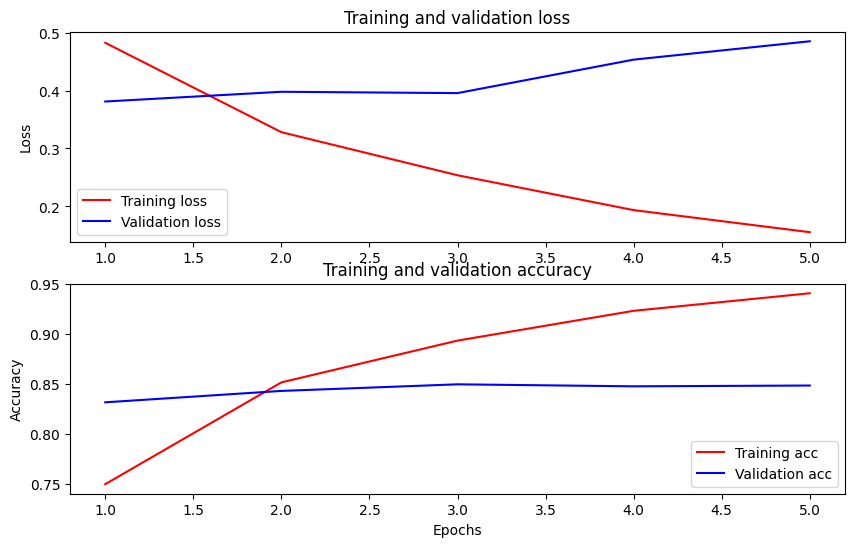

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999777
input: The movie was great!           : score: 0.997405
input: The movie was meh.             : score: 0.798326
input: The movie was okish.           : score: 0.060492
input: The movie was terrible...      : score: 0.001274

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999777
input: The movie was great!           : score: 0.997405
input: The movie was meh.             : score: 0.798326
input: The movie was okish.           : score: 0.060492
input: The movie was terrible...      : score: 0.001274



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999777
input: The movie was great!           : score: 0.997405
input: The movie was meh.             : score: 0.798326
input: The movie was okish.           : score: 0.060492
input: The movie was terrible...      : score: 0.001274



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.